# Menyiapkan Library yang Diperlukan

In [1]:
!pip install tensorflow

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'


In [3]:
print(os.environ.get('TF_USE_LEGACY_KERAS'))

1


In [4]:
import pandas as pd
import json
import glob
import re
import os
import shutil
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input

# Load Dataset

In [5]:
file_path = "/kaggle/input/fashion-product-images-small/styles.csv"

In [6]:
df = pd.read_csv(file_path, on_bad_lines='skip')

df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


# Eksplorasi Dataset

In [7]:
df_filtered = df[['id', 'articleType', 'baseColour', 'usage']]

df_filtered.head()

,id,articleType,baseColour,usage
0,15970,Shirts,Navy Blue,Casual
1,39386,Jeans,Blue,Casual
2,59263,Watches,Silver,Casual
3,21379,Track Pants,Black,Casual
4,53759,Tshirts,Grey,Casual


## Mengambil Kolom yang Diperlukan

In [8]:
df_UsageType = df_filtered[df_filtered['usage'].notna()]
df_UsageType = df_UsageType[df_filtered['articleType'].notna()]
df_UsageType = df_UsageType[['id', 'usage', 'articleType']]

df_UsageType.head()

/tmp/ipykernel_23/3716085341.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_UsageType = df_UsageType[df_filtered['articleType'].notna()]


,id,usage,articleType
0,15970,Casual,Shirts
1,39386,Casual,Jeans
2,59263,Casual,Watches
3,21379,Casual,Track Pants
4,53759,Casual,Tshirts


In [9]:
df_UsageType.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44107 entries, 0 to 44423
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           44107 non-null  int64 
 1   usage        44107 non-null  object
 2   articleType  44107 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


## Menghilangkan Tipe Fashion yang Memiliki Jumlah Kurang dari 100

In [10]:
type_df = df_UsageType['articleType'].value_counts()

type_filtered = type_df[type_df < 100].index
df_UsageType = df_UsageType[~df_UsageType['articleType'].isin(type_filtered)]

df_UsageType['articleType'].value_counts()

articleType
Tshirts                  7067
Shirts                   3214
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   928
Flip Flops                914
Sandals                   895
Briefs                    847
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Jeans                     609
Perfume and Body Mist     603
Shorts                    547
Trousers                  530
Flats                     500
Bra                       477
Dresses                   464
Sarees                    427
Earrings                  416
Deodorant                 347
Track Pants               304
Clutches                  290
Sweatshirts               285
Caps                      283
Nail Polish               27

## Mengambil Tipe Fashion yang Sesuai

In [11]:
categories_to_use = ['Tshirts', 'Shirts', 'Casual Shoes', 'Sports Shoes', 'Tops', 'Flip Flops',
    'Sandals', 'Backpacks', 'Formal Shoes', 'Jeans', '  Shorts', 'Trousers',
    'Flats', 'Heels', 'Dresses', 'Skirts', 'Caps', 'Jackets', 'Sweaters', 'Sweatshirts']

df_choosenCategories = df_UsageType[df_UsageType['articleType'].isin(categories_to_use)]
df_choosenCategories['articleType'].value_counts()

articleType
Tshirts         7067
Shirts          3214
Casual Shoes    2845
Sports Shoes    2036
Tops            1762
Heels           1323
Flip Flops       914
Sandals          895
Backpacks        724
Formal Shoes     637
Jeans            609
Trousers         530
Flats            500
Dresses          464
Sweatshirts      285
Caps             283
Sweaters         277
Jackets          258
Skirts           128
Name: count, dtype: int64

## Menghilangkan Usage Fashion yang Memiliki Jumlah Kurang dari 100

In [12]:
type_df = df_choosenCategories['usage'].value_counts()

type_filtered = type_df[type_df < 100].index
df_choosenCategories = df_choosenCategories[~df_choosenCategories['usage'].isin(type_filtered)]

df_choosenCategories['usage'].value_counts()

usage
Casual    19525
Sports     3276
Formal     1776
Name: count, dtype: int64

In [13]:
df_choosenCategories = df_choosenCategories.reset_index(drop = True)
df_choosenCategories = df_choosenCategories[['id', 'usage', 'articleType']]

df_choosenCategories.head()

,id,usage,articleType
0,15970,Casual,Shirts
1,39386,Casual,Jeans
2,53759,Casual,Tshirts
3,1855,Casual,Tshirts
4,26960,Casual,Shirts


## Memrevisi Beberapa Label pada Dataset

In [14]:
data_revision = [
    {"id": 11906, "articleType": "Flip Flops", "usage": "Casual"},
    {"id": 57491, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 59161, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 40315, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 46291, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 34815, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 14398, "articleType": "Heels", "usage": "Formal"},
    {"id": 57495, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 57490, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 35053, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 43511, "articleType": "Dresses", "usage": "Casual"},
    {"id": 59994, "articleType": "Dresses", "usage": "Casual"},
    {"id": 34069, "articleType": "Formal Shoes", "usage": "Formal"},
    {"id": 57116, "articleType": "Tops", "usage": "Casual"},
    {"id": 4340, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 26587, "articleType": "Sports Shoes", "usage": "Sports"},
    {"id": 34652, "articleType": "Casual Shoes", "usage": "Casual"},
    {"id": 10640, "articleType": "Casual Shoes", "usage": "Casual"},
]

df_rev = pd.DataFrame(data_revision)

df_choosenCategories.set_index("id", inplace=True)  
df_rev.set_index("id", inplace=True) 
df_choosenCategories.update(df_rev)  

df_choosenCategories.reset_index(inplace=True)

In [15]:
df_choosenCategories.head()

,id,usage,articleType
0,15970,Casual,Shirts
1,39386,Casual,Jeans
2,53759,Casual,Tshirts
3,1855,Casual,Tshirts
4,26960,Casual,Shirts


In [16]:
rules_rev = [
    {"articleType": "Sandals", "usage": "Formal", "new_usage": "Casual"},
    {"articleType": "Flats", "usage": "Sports", "new_usage": "Casual"},
    {"articleType": "Flip Flops", "usage": "Sports", "new_usage": "Casual"},
    {"articleType": "Skirts", "usage": "Sports", "action": "drop"},
    {"articleType": "Sweaters", "usage": "Sports", "new_usage": "Casual"},
]

for rule in rules_rev:
    if "action" in rule and rule["action"] == "drop":
        df_choosenCategories = df_choosenCategories[~((df_choosenCategories["articleType"] == rule["articleType"]) & (df_choosenCategories["usage"] == rule["usage"]))]
    else:
        df_choosenCategories.loc[
            (df_choosenCategories["articleType"] == rule["articleType"]) & (df_choosenCategories["usage"] == rule["usage"]),
            "usage",
        ] = rule["new_usage"]

In [17]:
df_choosenCategories['usage'].value_counts()

usage
Casual    19551
Sports     3255
Formal     1766
Name: count, dtype: int64

In [18]:
df_choosenCategories['articleType'].value_counts()

articleType
Tshirts         7067
Shirts          3181
Casual Shoes    2832
Sports Shoes    2038
Tops            1715
Heels           1311
Flip Flops       915
Sandals          894
Backpacks        713
Formal Shoes     631
Jeans            609
Trousers         523
Flats            486
Dresses          444
Sweatshirts      285
Caps             283
Sweaters         277
Jackets          256
Skirts           112
Name: count, dtype: int64

# Menyiapkan Dataset untuk Model

## Mengubah Kategori menjadi Integer

In [19]:
df_choosenCategories['id'] = df_choosenCategories['id'].astype(str) + ".jpg"

article_encoder = LabelEncoder()
usage_encoder = LabelEncoder()

df_choosenCategories['articleType_encoded'] = article_encoder.fit_transform(df_choosenCategories['articleType'])
df_choosenCategories['usage_encoded'] = usage_encoder.fit_transform(df_choosenCategories['usage'])

## Mengapus Baris yang Tidak Memiliki Gambar

In [20]:
import os

image_dir = "/kaggle/input/fashion-product-images-small/images/"
df_choosenCategories['file_path'] = df_choosenCategories['id'].apply(lambda x: os.path.join(image_dir, x))

df_choosenCategories['file_exists'] = df_choosenCategories['file_path'].apply(os.path.exists)

missing_files = df_choosenCategories[~df_choosenCategories['file_exists']]
print(f"Jumlah file gambar yang hilang: {len(missing_files)}")
print("File yang hilang:")
print(missing_files)

df_choosenCategories = df_choosenCategories[df_choosenCategories['file_exists']].drop(columns=['file_exists'])

Jumlah file gambar yang hilang: 4
File yang hilang:
              id   usage articleType  articleType_encoded  usage_encoded  \
3671   39403.jpg  Casual      Shirts                   11              0   
8894   39410.jpg  Casual      Shirts                   11              0   
17811  39401.jpg  Casual       Jeans                    9              0   
20121  39425.jpg  Casual     Tshirts                   18              0   

                                               file_path  file_exists  
3671   /kaggle/input/fashion-product-images-small/ima...        False  
8894   /kaggle/input/fashion-product-images-small/ima...        False  
17811  /kaggle/input/fashion-product-images-small/ima...        False  
20121  /kaggle/input/fashion-product-images-small/ima...        False  


In [21]:
articleType_dict = dict(zip(df_choosenCategories['articleType_encoded'], df_choosenCategories['articleType']))

usage_dict = dict(zip(df_choosenCategories['usage_encoded'], df_choosenCategories['usage']))

print("articleType_encoded : articleType =>", articleType_dict)
print("usage_encoded : usage =>", usage_dict)

articleType_encoded : articleType => {11: 'Shirts', 9: 'Jeans', 18: 'Tshirts', 2: 'Casual Shoes', 5: 'Flip Flops', 16: 'Tops', 10: 'Sandals', 15: 'Sweatshirts', 6: 'Formal Shoes', 4: 'Flats', 13: 'Sports Shoes', 7: 'Heels', 3: 'Dresses', 0: 'Backpacks', 1: 'Caps', 17: 'Trousers', 8: 'Jackets', 14: 'Sweaters', 12: 'Skirts'}
usage_encoded : usage => {0: 'Casual', 1: 'Formal', 2: 'Sports'}


## Memisahkan Dataset untuk Train, Validation, dan Test

In [22]:
train_df, temp_df = train_test_split(df_choosenCategories, test_size=0.3, stratify=df_choosenCategories['articleType'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['articleType'], random_state=42)

In [23]:
train_df.head()

,id,usage,articleType,articleType_encoded,usage_encoded,file_path
872,7939.jpg,Sports,Tshirts,18,2,/kaggle/input/fashion-product-images-small/ima...
23225,3178.jpg,Sports,Sports Shoes,13,2,/kaggle/input/fashion-product-images-small/ima...
22459,31959.jpg,Sports,Sports Shoes,13,2,/kaggle/input/fashion-product-images-small/ima...
3569,4252.jpg,Casual,Tshirts,18,0,/kaggle/input/fashion-product-images-small/ima...
1874,31574.jpg,Casual,Tshirts,18,0,/kaggle/input/fashion-product-images-small/ima...


In [24]:
source_dir = '/kaggle/input/fashion-product-images-small/images/'
target_dir = '/kaggle/working/data/'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

for index, row in df_choosenCategories.iterrows():
    image_filename = row['id']

    source_image_path = os.path.join(source_dir, image_filename)
    if os.path.exists(source_image_path):
        target_image_path = os.path.join(target_dir, image_filename)
        shutil.copy(source_image_path, target_image_path)
    else:
        df_choosenCategories = df_choosenCategories.drop(index)
        print(f"File {image_filename} tidak ditemukan di {source_dir}")

image_dir = target_dir

def parse_image(filename, article_label, usage_label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, {"article_output": article_label, "usage_output": usage_label}

def augment_image(image, labels):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, labels

def generator(df, image_dir):
    for _, row in df.iterrows():
        file_path = os.path.join(image_dir, row['id'])
        yield file_path, row['articleType_encoded'], row['usage_encoded']

def create_dataset_lazy(df, image_dir, batch_size=8, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(df, image_dir),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int64),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset_lazy(train_df, image_dir, batch_size=16, is_training=True)
val_dataset = create_dataset_lazy(val_df, image_dir, batch_size=16, is_training=False)
test_dataset = create_dataset_lazy(test_df, image_dir, batch_size=16, is_training=False)

# Model Klasifikasi Tipe dan Usage

## Membuat dan Melatih Model

In [25]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-10:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', name='dense_1')(x)
    x = Dense(128, activation='relu', name='dense_2')(x)
    x = Dense(64, activation='relu', name='dense_3')(x)
    x = Dense(32, activation='relu', name='dense_4')(x)

    # Output untuk articleType
    article_output = Dense(len(article_encoder.classes_), activation='softmax', name='article_output')(x)

    # Output untuk usage
    usage_output = Dense(len(usage_encoder.classes_), activation='softmax', name='usage_output')(x)

    model = Model(inputs=base_model.input, outputs=[article_output, usage_output])

    model.compile(
        optimizer='adam',
        loss={
            'article_output': 'sparse_categorical_crossentropy',
            'usage_output': 'sparse_categorical_crossentropy'
        },
        metrics={
            'article_output': 'accuracy',
            'usage_output': 'accuracy'
        }
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,        
    patience=3,        
    min_lr=1e-6
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[reduce_lr, early_stop]
)

Number of devices: 2
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/25


I0000 00:00:1733826307.121172     101 service.cc:145] XLA service 0x7cd2267b0120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733826307.121228     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733826307.121233     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733826307.296529     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1075/1075 [==============================] - 92s 44ms/step - loss: 1.2768 - article_output_loss: 0.8940 - usage_output_loss: 0.3828 - article_output_accuracy: 0.6932 - usage_output_accuracy: 0.8525 - val_loss: 7.8044 - val_article_output_loss: 6.7287 - val_usage_output_loss: 1.0757 - val_article_output_accuracy: 0.3680 - val_usage_output_accuracy: 0.7829 - lr: 0.0010
Epoch 2/25
1075/1075 [==============================] - 36s 33ms/step - loss: 0.9083 - article_output_loss: 0.6087 - usage_output_loss: 0.2995 - article_output_accuracy: 0.7841 - usage_output_accuracy: 0.8849 - val_loss: 1.3294 - val_article_output_loss: 0.9511 - val_usage_output_loss: 0.3783 - val_article_output_accuracy: 0.7400 - val_usage_output_accuracy: 0.8763 - lr: 0.0010
Epoch 3/25
1075/1075 [==============================] - 37s 34ms/step - loss: 0.8097 - article_output_loss: 0.5303 - usage_output_loss: 0.2794 - article_output_accuracy: 0.8074 - usage_output_accuracy: 0.8946 - val_loss: 1.2501 - val_article_output_

## Mengevaluasi Model

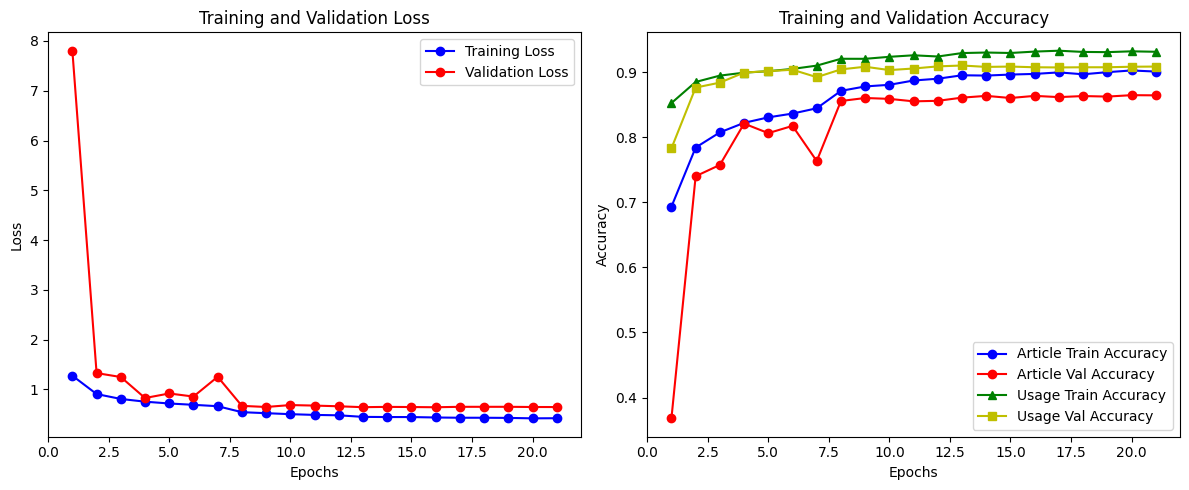

In [26]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

article_train_acc = history_dict['article_output_accuracy']
article_val_acc = history_dict['val_article_output_accuracy']

usage_train_acc = history_dict['usage_output_accuracy']
usage_val_acc = history_dict['val_usage_output_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, article_train_acc, 'bo-', label='Article Train Accuracy')
plt.plot(epochs, article_val_acc, 'ro-', label='Article Val Accuracy')
plt.plot(epochs, usage_train_acc, 'g^-', label='Usage Train Accuracy')
plt.plot(epochs, usage_val_acc, 'ys-', label='Usage Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
test_loss, test_article_loss, test_usage_loss, test_article_acc, test_usage_acc = model.evaluate(test_dataset)

print(f"Total Test Loss: {test_loss:.4f}")
print(f"Test Article Loss: {test_article_loss:.4f}")
print(f"Test Usage Loss: {test_usage_loss:.4f}")
print(f"Test Article Accuracy: {test_article_acc:.4f}")
print(f"Test Usage Accuracy: {test_usage_acc:.4f}")

231/231 [==============================] - 5s 22ms/step - loss: 0.5953 - article_output_loss: 0.3718 - usage_output_loss: 0.2235 - article_output_accuracy: 0.8687 - usage_output_accuracy: 0.9164
Total Test Loss: 0.5953
Test Article Loss: 0.3718
Test Usage Loss: 0.2235
Test Article Accuracy: 0.8687
Test Usage Accuracy: 0.9164


231/231 [==============================] - 15s 21ms/step


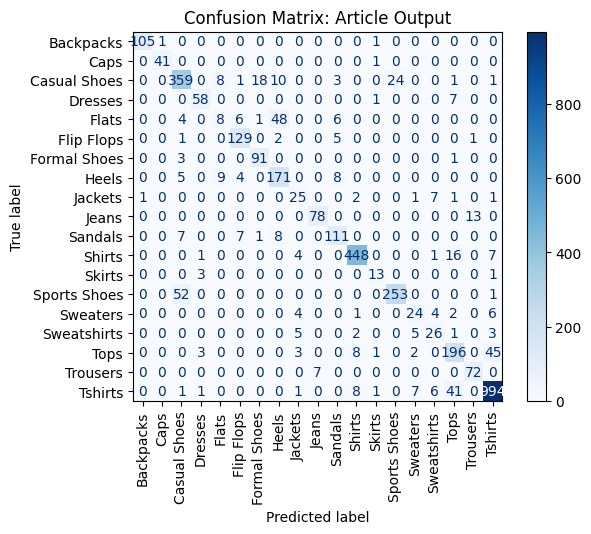

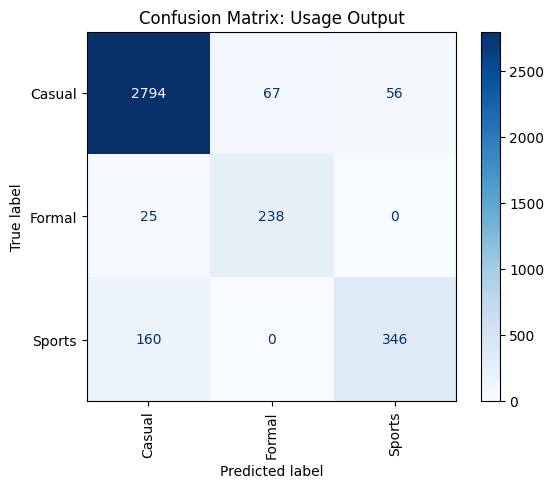

In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(test_dataset)

article_predictions = np.argmax(predictions[0], axis=1)
usage_predictions = np.argmax(predictions[1], axis=1)

true_labels = list(test_dataset.as_numpy_iterator())
true_article_labels = np.concatenate([y['article_output'] for _, y in true_labels])
true_usage_labels = np.concatenate([y['usage_output'] for _, y in true_labels])

article_cm = confusion_matrix(true_article_labels, article_predictions)
ConfusionMatrixDisplay(article_cm, display_labels=article_encoder.classes_).plot(
    cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix: Article Output")
plt.show()

usage_cm = confusion_matrix(true_usage_labels, usage_predictions)
ConfusionMatrixDisplay(usage_cm, display_labels=usage_encoder.classes_).plot(
    cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix: Usage Output")
plt.show()

# Menyimpan Model

In [31]:
model.save('/kaggle/working/hybridmodel.h5') 